In [2]:
import tensorflow as tf
import pathlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.keras import activations
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation, Add

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
country_images_root = pathlib.Path("/home/pascal_steiger/Downloads/data3/")

In [3]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr

In [4]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data3/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

img_df.sample(n=10)

,path,label
1445,/home/pascal_steiger/Downloads/data3/PRT/img_P...,PRT
250,/home/pascal_steiger/Downloads/data3/ISL/img_I...,ISL
1913,/home/pascal_steiger/Downloads/data3/PRT/img_P...,PRT
1299,/home/pascal_steiger/Downloads/data3/PRT/img_P...,PRT
131,/home/pascal_steiger/Downloads/data3/ISL/img_I...,ISL
1627,/home/pascal_steiger/Downloads/data3/PRT/img_P...,PRT
2753,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE
1931,/home/pascal_steiger/Downloads/data3/PRT/img_P...,PRT
2312,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE
2052,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE


In [5]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)

                                                   path label
954   /home/pascal_steiger/Downloads/data3/ISL/img_I...   ISL
933   /home/pascal_steiger/Downloads/data3/ISL/img_I...   ISL
2938  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
2400  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
1983  /home/pascal_steiger/Downloads/data3/PRT/img_P...   PRT
(2409, 2)
                                                   path label
1027  /home/pascal_steiger/Downloads/data3/PRT/img_P...   PRT
2700  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
2462  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
2023  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
2872  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
(603, 2)


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(400, 400),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(400, 400),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 2409 validated image filenames belonging to 3 classes.
Found 603 validated image filenames belonging to 3 classes.


In [9]:
with tf.device("/device:GPU:1"):   
    I = Input(shape=(400,400,3), dtype="float32")

    c2d1= Conv2D(32, (3, 3), (2, 2), activation="relu")(I)
    b1 = BatchNormalization()(c2d1)
    c2d2= Conv2D(64, (3, 3), activation="relu")(b1)
    b2 = BatchNormalization()(c2d2)

    c1d1= Conv2D(1, 1, (2, 2))(b2)
    b3 = BatchNormalization()(c1d1)

    sc2d1= SeparableConv2D(128, (3, 3), padding="same")(b2)
    b4 = BatchNormalization()(sc2d1)
    relu1= Activation(activations.relu)(b4)
    sc2d2= SeparableConv2D(128, (3, 3), padding="same")(relu1)
    b5 = BatchNormalization()(sc2d2)
    mp1= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b5)

    add1 = Add()([b3, mp1])

    c1d2= Conv2D(1, 1, (2, 2))(add1)
    b6 = BatchNormalization()(c1d2)

    relu2= Activation(activations.relu)(add1)
    sc2d3= SeparableConv2D(256, (3, 3), padding="same")(relu2)
    b7 = BatchNormalization()(sc2d3)
    relu3= Activation(activations.relu)(b7)
    sc2d4= SeparableConv2D(256, (3, 3), padding="same")(relu3)
    b8 = BatchNormalization()(sc2d4)
    mp2= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b8)

    add2 = Add()([b6, mp2])

    c1d3= Conv2D(1, 1, (2, 2))(add2)
    b9 = BatchNormalization()(c1d3)

    relu4= Activation(activations.relu)(add2)
    sc2d5= SeparableConv2D(728, (3, 3), padding="same")(relu4)
    b10 = BatchNormalization()(sc2d5)
    relu5= Activation(activations.relu)(b10)
    sc2d6= SeparableConv2D(728, (3, 3), padding="same")(relu5)
    b11 = BatchNormalization()(sc2d6)
    mp3= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b11)

    add3 = Add()([b9, mp3])

    relu6= Activation(activations.relu)(add3)
    sc2d7= SeparableConv2D(728, (3, 3), padding="same")(relu6)
    b12 = BatchNormalization()(sc2d7)
    relu7= Activation(activations.relu)(b12)
    sc2d8= SeparableConv2D(728, (3, 3), padding="same")(relu7)
    b13 = BatchNormalization()(sc2d8)

    add4 = Add()([add3, b13])

    relu8= Activation(activations.relu)(add4)
    sc2d9= SeparableConv2D(728, (3, 3), padding="same")(relu8)
    b14 = BatchNormalization()(sc2d9)
    relu9= Activation(activations.relu)(b14)
    sc2d10= SeparableConv2D(728, (3, 3), padding="same")(relu9)
    b15 = BatchNormalization()(sc2d10)

    add5 = Add()([add4, b15])

    relu10= Activation(activations.relu)(add5)
    sc2d11= SeparableConv2D(728, (3, 3), padding="same")(relu10)
    b16 = BatchNormalization()(sc2d11)
    relu11= Activation(activations.relu)(b16)
    sc2d12= SeparableConv2D(728, (3, 3), padding="same")(relu11)
    b17 = BatchNormalization()(sc2d12)

    add6 = Add()([add5, b17])

    relu12= Activation(activations.relu)(add6)
    sc2d13= SeparableConv2D(728, (3, 3), padding="same")(relu12)
    b18 = BatchNormalization()(sc2d13)
    relu13= Activation(activations.relu)(b18)
    sc2d14= SeparableConv2D(728, (3, 3), padding="same")(relu13)
    b19 = BatchNormalization()(sc2d14)

    add7 = Add()([add6, b19])

    relu14= Activation(activations.relu)(add7)
    sc2d15= SeparableConv2D(728, (3, 3), padding="same")(relu14)
    b20 = BatchNormalization()(sc2d15)
    relu15= Activation(activations.relu)(b20)
    sc2d16= SeparableConv2D(728, (3, 3), padding="same")(relu15)
    b21 = BatchNormalization()(sc2d16)

    add8 = Add()([add7, b21])

    c1d4= Conv2D(1, 1, (2, 2))(add8)
    b21 = BatchNormalization()(c1d4)

    relu16= Activation(activations.relu)(add8)
    sc2d17= SeparableConv2D(728, (3, 3), padding="same")(relu16)
    b22 = BatchNormalization()(sc2d17)
    relu17= Activation(activations.relu)(b22)
    sc2d18= SeparableConv2D(1024, (3, 3), padding="same")(relu17)
    b23 = BatchNormalization()(sc2d18)
    mp9= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b23)

    add9 = Add()([b21, mp9])

    sc2d19= SeparableConv2D(1536, (3, 3), activation="relu")(add9)
    b24 = BatchNormalization()(sc2d19)
    sc2d20= SeparableConv2D(2048, (3, 3), activation="relu")(b24)
    b25 = BatchNormalization()(sc2d20)

    gap = GlobalAveragePooling2D()(b25)

    flat = Flatten()(gap)
    dense = Dense(1024, activation='relu')(flat)
    dropout = Dropout(0.3)(dense)
    dense2 = Dense(512, activation='relu')(dropout)
    dropout2 = Dropout(0.1)(dense2)
    dense3 = Dense(3, activation='softmax')(dropout2)

    model = tf.keras.Model(I, dense3)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [11]:
with tf.device("/device:GPU:1"):
    model.compile(optimizer = tf.optimizers.Nadam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [12]:
with tf.device("/device:GPU:1"):
    history = model.fit(train_generator,
      #steps_per_epoch=2000 // 32,  
      epochs=100,
      verbose=1,
      validation_data = validation_generator,
      callbacks = callbacks)

Epoch 1/100
76/76 [==============================] - 143s 2s/step - loss: 0.9207 - sparse_categorical_accuracy: 0.5986 - val_loss: 1.0996 - val_sparse_categorical_accuracy: 0.3250
Epoch 2/100
76/76 [==============================] - 125s 2s/step - loss: 0.6983 - sparse_categorical_accuracy: 0.7082 - val_loss: 1.1021 - val_sparse_categorical_accuracy: 0.3250
Epoch 3/100
76/76 [==============================] - 124s 2s/step - loss: 0.6106 - sparse_categorical_accuracy: 0.7634 - val_loss: 1.1584 - val_sparse_categorical_accuracy: 0.3250
Epoch 4/100
76/76 [==============================] - 125s 2s/step - loss: 0.5610 - sparse_categorical_accuracy: 0.7763 - val_loss: 1.1589 - val_sparse_categorical_accuracy: 0.3250
Epoch 5/100
76/76 [==============================] - 125s 2s/step - loss: 0.5147 - sparse_categorical_accuracy: 0.7974 - val_loss: 1.2189 - val_sparse_categorical_accuracy: 0.3250
Epoch 6/100
76/76 [==============================] - 125s 2s/step - loss: 0.4992 - sparse_categorica

Epoch 45/100
76/76 [==============================] - 125s 2s/step - loss: 0.1013 - sparse_categorical_accuracy: 0.9610 - val_loss: 0.2735 - val_sparse_categorical_accuracy: 0.9088
Epoch 46/100
76/76 [==============================] - 125s 2s/step - loss: 0.0628 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.2662 - val_sparse_categorical_accuracy: 0.9138
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping


In [10]:
with tf.device("/device:GPU:1"):
    model.save('CNN_v5_fullNet-data3.h5')

NameError: name 'model' is not defined

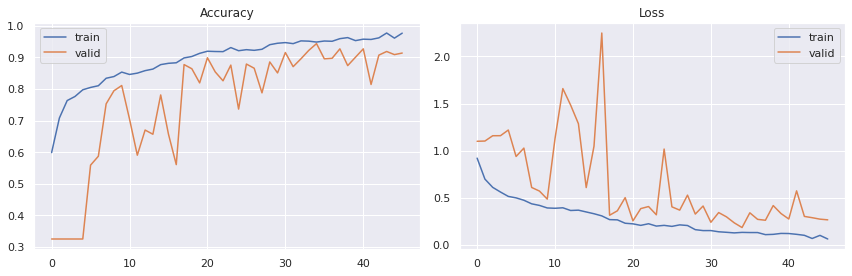

In [20]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(400,400)_v5-data3.png')

plt.show()

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 199, 199, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 199, 199, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 197, 197, 64) 18496       batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
model2 = tf.keras.models.load_model('CNN_v5_fullNet-data3.h5')

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=603
batch_size=32
Y_pred = model2.predict(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = sorted(labelStringArr)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[184   7   5]
 [  2 208  10]
 [  6   4 177]]
Classification Report
              precision    recall  f1-score   support

         CHE       0.96      0.94      0.95       196
         ISL       0.95      0.95      0.95       220
         PRT       0.92      0.95      0.93       187

    accuracy                           0.94       603
   macro avg       0.94      0.94      0.94       603
weighted avg       0.94      0.94      0.94       603

